$$
\mathbf{u} \cdot \nabla \mathbf{u} = \frac{1}{Re} \nabla^2 \mathbf{u} - \nabla p
$$

![](https://www.cfd-online.com/W/images/a/a3/Ldc_geom.png)

In [5]:
import torch
import torch.nn as nn

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

mlp = nn.Sequential(
    nn.Linear(2, 100),
    Sine(), 
    nn.Linear(100, 100), 
    Sine(),
    nn.Linear(100, 100), 
    Sine(),
    nn.Linear(100, 3)
)

device = "cuda"

mlp.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Sine()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Sine()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): Sine()
  (6): Linear(in_features=100, out_features=3, bias=True)
)

In [6]:
def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True, only_inputs=True)
    return grads

def computeMixture(N_SAMPLES):
    m = torch.zeros(N_SAMPLES, device=device)
    s = torch.ones(N_SAMPLES, device=device)*0.2
    x1 = torch.normal(m, s).clip(0,1)

    m = torch.ones(N_SAMPLES, device=device)
    s = torch.ones(N_SAMPLES, device=device)*0.2
    x2 = torch.normal(m, s).clip(0,1)

    return torch.cat([x1, x2]).view(-1)

In [7]:
from fastprogress.fastprogress import progress_bar

N_STEPS = 100000
N_SAMPLES = 1000
N_SAMPLES_0 = 1000

optimizer = torch.optim.Adam(mlp.parameters())
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.4*N_STEPS), int(0.8*N_STEPS)], gamma=0.1)
criterion = torch.nn.MSELoss()
mlp.train()
Re = 100
mlp.to(device)

mb = progress_bar(range(1, N_STEPS+1))

for step in mb:

    # optimize for PDE
    x = torch.rand(N_SAMPLES, device=device)
    y = torch.rand(N_SAMPLES, device=device)

    # x = computeMixture(int(N_SAMPLES / 2))
    # y = computeMixture(int(N_SAMPLES / 2))

    X = torch.stack([  
        x, 
        y,
    ], axis=-1)
    X.requires_grad = True
    
    y_hat = mlp(X) 
    u, v, p = y_hat[:,0], y_hat[:,1], y_hat[:,2]
    
    grads = computeGrads(u, X)       
    dudx, dudy = grads[:, 0], grads[:, 1]
    
    grads = computeGrads(v, X)       
    dvdx, dvdy = grads[:, 0], grads[:, 1]
    
    grads = computeGrads(p, X)       
    dpdx, dpdy = grads[:, 0], grads[:, 1]
    
    du2dx2 = computeGrads(dudx, X)[:, 0]       
    du2dy2 = computeGrads(dudy, X)[:, 1]       
    dv2dx2 = computeGrads(dvdx, X)[:, 0]       
    dv2dy2 = computeGrads(dvdy, X)[:, 1]
        
    pde_loss = criterion(dudx, - dvdy) + \
        criterion(u*dudx + v*dudy + dpdx, (1./Re)*(du2dx2 + du2dy2)) + \
        criterion(u*dvdx + v*dvdy + dpdy, (1./Re)*(dv2dx2 + dv2dy2))
    
    # optimize for boundary conditions
    # left
    y = torch.rand(N_SAMPLES_0, device=device)
    Y0 = torch.stack([  
        torch.zeros(N_SAMPLES_0, device=device), 
        y,
    ], axis=-1)
    Y0.requires_grad = True
    p_y0 = torch.stack([  
        torch.zeros(N_SAMPLES_0, device=device), 
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    y_y0 = mlp(Y0) 
    y0_uv_loss = criterion(y_y0[:,:2], p_y0)
    p = y_y0[:,2]
    dpdx = computeGrads(p, Y0)[:,0]
    y0_p_loss = criterion(dpdx, torch.zeros(len(dpdx), device=device))
    # right
    y = torch.rand(N_SAMPLES_0, device=device)
    Y1 = torch.stack([  
        torch.ones(N_SAMPLES_0, device=device), 
        y,
    ], axis=-1)
    Y1.requires_grad = True
    p_y1 = torch.stack([  
        torch.zeros(N_SAMPLES_0, device=device), 
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    y_y1 = mlp(Y1) 
    y1_uv_loss = criterion(y_y1[:,:2], p_y1)
    p = y_y1[:,2]
    dpdx = computeGrads(p, Y1)[:,0]
    y1_p_loss = criterion(dpdx, torch.zeros(len(dpdx), device=device))
    # bot
    x = torch.rand(N_SAMPLES_0, device=device)
    X0 = torch.stack([  
        x, 
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    X0.requires_grad = True
    p_x0 = torch.stack([  
        torch.zeros(N_SAMPLES_0, device=device), 
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    y_x0 = mlp(X0) 
    x0_uv_loss = criterion(y_x0[:,:2], p_x0)
    p = y_x0[:,2]
    dpdy = computeGrads(p, X0)[:,1]
    x0_p_loss = criterion(dpdy, torch.zeros(len(dpdy), device=device))
    # top
    x = torch.rand(N_SAMPLES_0, device=device)
    X1 = torch.stack([  
        x, 
        torch.ones(N_SAMPLES_0, device=device),
    ], axis=-1)
    X1.requires_grad = True
    p_x1 = torch.stack([  
        torch.ones(N_SAMPLES_0, device=device), 
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    y_x1 = mlp(X1) 
    x1_uv_loss = criterion(y_x1[:,:2], p_x1)
    p = y_x1[:,2]
    dpdy = computeGrads(p, X1)[:,1]
    x1_p_loss = criterion(dpdy, torch.zeros(len(dpdy), device=device))

    bound_loss = y0_uv_loss + y0_p_loss + \
        x1_uv_loss + x1_p_loss + \
        x0_uv_loss + x0_p_loss + \
        y1_uv_loss + y1_p_loss 
         
         
    # update
    optimizer.zero_grad()
    loss = 10.*bound_loss + pde_loss 
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    mb.comment = f'pde_loss {pde_loss.item():.5f} bound_loss {bound_loss.item():.5f}'


In [8]:
import numpy as np

def run_mlp(Nx, Ny):
    x = np.linspace(0,1,Nx)
    y = np.linspace(0,1,Ny)
    X = np.stack(np.meshgrid(x,y), -1).reshape(-1, 2)
    X = torch.from_numpy(X).float()
    mlp.eval()
    mlp.cpu()
    with torch.no_grad():
        p = mlp(X)
    return p[:,0].reshape(Ny,Nx), p[:,1].reshape(Ny,Nx), p[:,2].reshape(Ny,Nx), x, y

In [15]:
Nx, Ny = 100, 100
u, v, p, x, y = run_mlp(Nx, Ny)

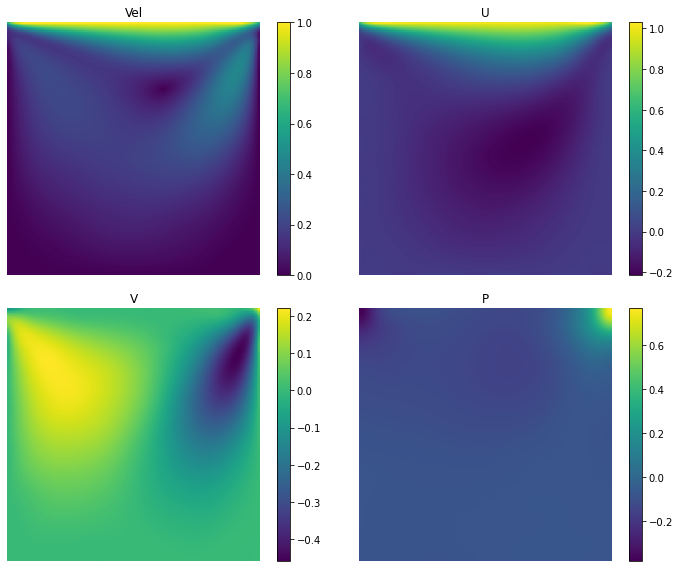

In [16]:
import matplotlib.pyplot as plt 

# plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
vel = np.sqrt(u**2 + v**2)
im=ax1.imshow(vel, vmin=0, vmax=1, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax1)
ax1.set_xlabel("x", fontsize=14)
ax1.set_ylabel("y", fontsize=14, rotation=np.pi/2)
ax1.set_title("Vel")
ax1.axis(False)
im=ax2.imshow(u, vmin=u.min(), vmax=u.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax2)
ax2.set_title("U")
im=ax3.imshow(v, vmin=v.min(), vmax=v.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax3)
ax2.axis(False)
ax3.axis(False)
ax3.set_title("V")
im=ax4.imshow(p, vmin=p.min(), vmax=p.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax4)
ax4.axis(False)
ax4.set_title("P")
plt.tight_layout()
plt.show()

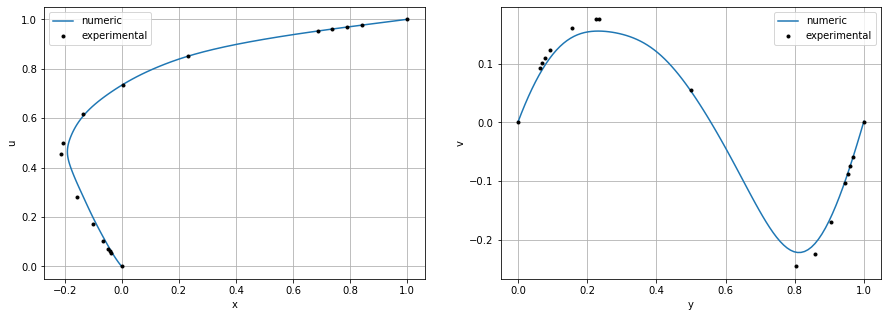

In [17]:
import pandas as pd

# profiles

mid_u = u[:,len(u)//2]
mid_v = v[len(v)//2,:]
exp_u = pd.read_csv('dc_100_ux.csv', header=None).values
exp_v= pd.read_csv('dc_100_uy.csv', header=None).values

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax1.plot(mid_u, y, label="numeric")
ax1.plot(exp_u[:,0], exp_u[:,1], '.k', label="experimental")
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.legend()
ax1.grid(True)
ax2 = plt.subplot(122)
ax2.plot(x,mid_v, label="numeric")
ax2.plot(exp_v[:,0], exp_v[:,1], '.k', label="experimental")
ax2.legend()
ax2.set_xlabel('y')
ax2.set_ylabel('v')
ax2.grid(True)
plt.show()